In [1]:
import numpy as np
import MDAnalysis as mda
import timeit
import matplotlib.pyplot as plt  

u = mda.Universe("prd.tpr", "prd_whole.xtc")
p = u.select_atoms("name OW")
box = np.array([65, 80, 60])

In [2]:
import numpy as np

class surface_protein:
    """
    Args:
        box(np.ndarray): An array of [Lx,Ly,Lz]
        radius(float): sphere radius in Angstrom
        universe: MDAnalysis universe
        time_array(np.ndarray): An array of time
   
    """
    
    def __init__(self,box,radius,universe,time_array):
        
        # Length of the box
        self.box = box
        self.Lx,self.Ly,self.Lz = box
     
        # sphere radius
        self.radius = radius
        
        # universe
        self.u = universe
        
        # time_array
        self.time_array = time_array
        
    def surface_protein_idx(self,protein,water):
        """
        Args:
            get surface protein index
            pos_p(np.ndarray) = position of protein
            pos_w(np.ndarray) = position of water            
        """
        
        pos_p = protein.positions
        pos_w = water.positions
        dist = np.abs(pos_w[:,np.newaxis,:] - pos_p)
        cond = dist > box/2
        dr = box*cond - dist 
        distance = np.sqrt((dr**2).sum(axis=-1))

        idx = np.argmin(distance, axis = 1)
        idx = np.unique(idx)
        
        idx = protein[idx].indices

        return idx
    
    def time_surface_protein_idx(self):
        """
        Args:
            Found that surface protein index varies with time.
            This will search surface protein index for time_array and add alltogether.
            Most generous surface protein index
        """
    
        time_ndx = []
        u = self.u
        
        for i in self.time_array:
            u.trajectory[np.int(i)]
            protein = u.select_atoms('protein and not (name H*)')
            water = u.select_atoms('name OW')
            nn = self.surface_protein_idx(protein,water)
            time_ndx += [nn]
            
        reference = time_ndx[0]
        for i in time_ndx:
            new = np.concatenate((reference,i))
            new = np.unique(new)
            reference = new
        
        return new
    
    @staticmethod
    def save_idx(idx, file_name):
        file = open(file_name, 'w')
        for i in idx:
            file.write(np.str(i+1)+"\n")
        file.close()
        


In [22]:
import numpy as np

def water_in_sphere(protein, water, radius):
    pos_p = protein.positions
    pos_w = water.positions
    dist = np.abs(pos_w[:,np.newaxis,:] - pos_p)
    cond = dist > box/2
    dr = box*cond - dist 
    distance = np.sqrt((dr**2).sum(axis=-1))
    
    condd = distance < radius
    
    nn = np.any(condd, axis = 1)
    
    probe_water = np.count_nonzero(nn)
    
    return probe_water,nn

def time_water_in_sphere(protein, water, radius, time_array, universe):
    u = universe
    prob_water = []
    for i in time_array:
        u.trajectory[np.int(i)]
        probe_water,_ = water_in_sphere(protein, water, radius)
        prob_water += [probe_water]
    
    return np.array(prob_water)

In [4]:
u1 = mda.Universe("prd.tpr", "prd_whole_1frame_protein.xtc")
box = np.array([65, 80, 60])

a = surface_protein(box,12,u1,np.linspace(100,1000,500))
u1.trajectory[0]
idx = a.surface_protein_idx(u1.select_atoms('protein and not (name H*)'), u1.select_atoms('name OW'))
hh = np.str(idx)
hh = hh.replace('[','')
hh = hh.replace(']','')

protein1= u1.select_atoms("index"+hh)
water1 = u1.select_atoms("name OW")

In [108]:
a.save_idx(idx, 'surface.ndx')

In [5]:
water_count = water_in_sphere(protein1, water1, 12)
print(water_count)
prob_water1 = time_water_in_sphere(protein1, water1, 12, np.linspace(100,1000,500), u1)

1915


1878.27
stdev of prob_water1 is 14.350787434841338


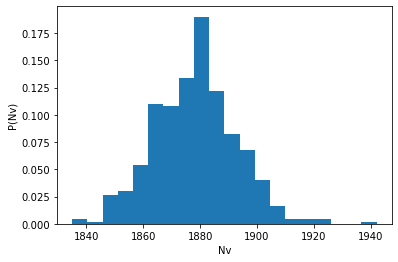

In [14]:
counts, bins = np.histogram(prob_water1, bins =20)
counts = counts/np.sum(counts)
plt.hist(bins[:-1], bins, weights=counts)
plt.xlabel('Nv')
plt.ylabel('P(Nv)')
print(np.average(prob_water1))
print(f'stdev of prob_water1 is {np.std(prob_water1)}')

In [15]:
-------------------to get atom name change-----------------
u3 = mda.Universe('prd2.gro', formate='gro')

In [25]:
protein3 = u3.select_atoms("index"+hh)
water3 = u3.select_atoms("name OW")

In [26]:
probe_water, nn = water_in_sphere(protein3, water3, 12)

In [44]:
for i in range(len(nn)):
    if nn[i] == True:
        index = water3[i].index
        u3.atoms[index].residue.resname = 'probe_water'
u3.atoms.write('prd2.gro', reindex=False)

In [31]:
print(water3[0])

<Atom 1032: OW of type O of resname SOL, resid 84 and segid SYSTEM>


In [10]:
np.sum(counts)

500

In [93]:
u1 = mda.Universe("prd.tpr", "prd_whole_1frame_protein.xtc")
box = np.array([65, 80, 60])

u.trajectory[0]
t_idx = a.time_surface_protein_idx()

In [94]:
hh2 = np.str(t_idx)
hh2 = hh2.replace('[','')
hh2 = hh2.replace(']','')

protein2= u1.select_atoms("index"+hh2)
water2 = u1.select_atoms("name OW")

In [95]:
water_count = water_in_sphere(protein2, water2, 12)
print(water_count)
prob_water2 = time_water_in_sphere(protein2, water2, 12, np.linspace(10,1000,500), u1)

1915


1878.0
stdev of prob_water2 is 14.14369117309905


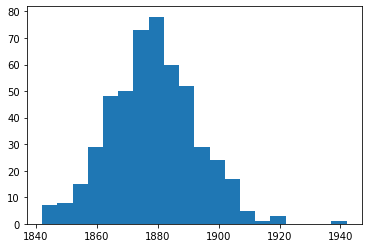

In [100]:
counts, bins = np.histogram(prob_water2, bins = 20)
plt.hist(bins[:-1], bins, weights=counts)
print(np.average(prob_water2))
print(f'stdev of prob_water2 is {np.std(prob_water2)}')

In [43]:

protein = u.select_atoms('protein and not (name H*)')
u.trajectory[4]
print(protein.positions)

[[33.100002 58.590004 27.730003]
 [31.970003 57.630005 27.640001]
 [31.170002 57.900005 26.390001]
 ...
 [28.79     20.61     32.39    ]
 [29.52     20.46     31.380003]
 [28.27     19.650002 32.97    ]]


In [4]:
a = surface_protein(box, 12, u, np.linspace(10,200,191))

In [5]:
idx = a.surface_protein_idx(u.select_atoms('protein and not (name H*)'), u.select_atoms('name OW'))

In [7]:
t_idx = a.time_surface_protein_idx()

In [6]:
# a.save_idx(idx, 'one_surface.ndx')

In [161]:
print(f'idx shape is {idx.shape}')
print(f't_idx shape is {t_idx.shape}')

idx shape is (189,)
t_idx shape is (289,)


In [28]:
mol = u.select_atoms("index"+hhhh)

In [27]:
hh = np.str(idx)
hhh = hh.replace('[','')
hhhh = hhh.replace(']','')
print(hhhh)

   0    6   13   14   19   23   26   33   35   39   42   45   49   50
   52   55   56   57   59   61   66   71   75   78   88   95   99  102
  105  107  110  113  130  134  137  138  140  145  149  154  164  171
  175  181  185  195  202  207  211  212  231  234  240  249  250  254
  269  271  275  287  291  311  315  327  328  332  355  356  369  371
  373  394  398  403  414  417  420  425  440  444  445  456  460  473
  480  484  490  494  512  516  528  529  541  546  550  555  560  562
  566  569  579  590  591  592  603  607  627  631  639  643  644  648
  667  670  673  676  690  691  712  714  716  723  735  736  738  753
  756  757  758  769  773  786  793  797  808  809  810  812  830  834
  846  847  866  869  870  872  874  875  877  879  882  885  887  893
  896  899  904  914  919  921  925  928  931  933  943  946  948  955
  959  963  965  970  971  972  976  987  988  990  992  995  999 1001
 1005 1010 1015 1023 1026 1029 1030


In [29]:
mol

<AtomGroup with 189 atoms>

In [11]:
print(np.str(idx))

[   0    6   13   14   19   23   26   33   35   39   42   45   49   50
   52   55   56   57   59   61   66   71   75   78   88   95   99  102
  105  107  110  113  130  134  137  138  140  145  149  154  164  171
  175  181  185  195  202  207  211  212  231  234  240  249  250  254
  269  271  275  287  291  311  315  327  328  332  355  356  369  371
  373  394  398  403  414  417  420  425  440  444  445  456  460  473
  480  484  490  494  512  516  528  529  541  546  550  555  560  562
  566  569  579  590  591  592  603  607  627  631  639  643  644  648
  667  670  673  676  690  691  712  714  716  723  735  736  738  753
  756  757  758  769  773  786  793  797  808  809  810  812  830  834
  846  847  866  869  870  872  874  875  877  879  882  885  887  893
  896  899  904  914  919  921  925  928  931  933  943  946  948  955
  959  963  965  970  971  972  976  987  988  990  992  995  999 1001
 1005 1010 1015 1023 1026 1029 1030]


In [106]:
a = surface_protein(box, 12, u, np.linspace(10,200,191))

In [107]:
a.save_idx(time_ndx, 'hello.ndx')

In [108]:
time_ndx.shape

(289,)

In [102]:
time_ndx = a.time_surface_protein_idx()

In [103]:
time_ndx

array([  0,   1,   2,   4,   5,   6,   8,   9,  11,  12,  15,  17,  18,
        19,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,
        34,  35,  37,  38,  39,  40,  42,  46,  48,  49,  51,  52,  53,
        54,  55,  56,  57,  58,  59,  61,  67,  68,  70,  71,  72,  74,
        75,  76,  77,  79,  81,  83,  89,  93,  94,  95,  96,  97,  98,
       100, 105, 106, 107, 108, 110, 113, 114, 115, 116, 127, 128, 131,
       134, 135, 136, 137, 139, 147, 148, 149, 151, 155, 156, 164, 168,
       169, 173, 174, 175, 176, 177, 178, 179, 180, 185, 189, 190, 191,
       192, 197, 198, 199, 200, 201, 202, 204, 213, 214, 215, 217, 219,
       220, 221, 222, 223, 224, 226, 231, 233, 234, 235, 236, 237, 239,
       242, 243, 244, 246, 251, 252, 256, 257, 260, 261, 263, 272, 273,
       274, 280, 281, 282, 290, 293, 295, 296, 298, 301, 302, 303, 305,
       306, 308, 310, 313, 314, 315, 316, 317, 318, 319, 320, 323, 324,
       325, 327, 330, 332, 336, 337, 342, 343, 344, 345, 347, 35

In [ ]:
time_ndx

In [10]:
protein = u.select_atoms('protein and not (name H*)')
water = u.select_atoms('name OW')

In [25]:
idx = a.get_nn_idx(protein,water)

In [66]:
0:2

SyntaxError: illegal target for annotation (<ipython-input-66-48e2e1eb5542>, line 1)

In [64]:
aaa[0]

<Atom 1: N of type N3 of resname GLN, resid 0 and segid seg_0_Protein>

In [59]:
bbb = u.select_atoms("protein")

In [61]:
bbb[0]

<Atom 1: N of type N3 of resname GLN, resid 0 and segid seg_0_Protein>

In [55]:
aaa[51]

<Atom 52: H of type H of resname GLY, resid 4 and segid seg_0_Protein>

In [26]:
idx

array([  0,   2,   5,   6,   9,  11,  12,  17,  18,  19,  21,  23,  25,
        26,  27,  28,  29,  30,  31,  32,  34,  37,  39,  42,  48,  52,
        53,  55,  57,  58,  59,  61,  71,  72,  74,  75,  76,  79,  81,
        83,  89,  93,  94,  98, 100, 106, 110, 113, 115, 116, 127, 128,
       131, 136, 137, 139, 147, 148, 149, 155, 156, 168, 169, 176, 177,
       179, 191, 192, 199, 200, 201, 214, 215, 217, 222, 223, 224, 226,
       234, 236, 237, 243, 244, 252, 256, 257, 261, 263, 273, 274, 281,
       282, 290, 293, 295, 298, 301, 302, 303, 305, 310, 315, 316, 317,
       323, 324, 336, 337, 342, 344, 345, 347, 357, 358, 359, 360, 367,
       368, 381, 382, 383, 387, 393, 394, 396, 404, 405, 406, 407, 413,
       414, 422, 426, 427, 433, 434, 435, 437, 447, 448, 455, 456, 467,
       468, 469, 470, 471, 472, 473, 474, 476, 478, 479, 481, 482, 483,
       485, 490, 493, 494, 495, 497, 499, 500, 505, 506, 508, 512, 513,
       516, 517, 519, 520, 521, 523, 529, 530, 531, 532, 533, 53

In [109]:
def get_nn_idx(protein, water):
    pos_p = protein.positions
    pos_w = water.positions
    dist = np.abs(pos_w[:,np.newaxis,:] - pos_p)
    cond = dist > box/2
    dr = box*cond - dist 
    distance = np.sqrt((dr**2).sum(axis=-1))
    
    idx = np.argmin(distance, axis = 1)
    idx = np.unique(idx)
    
    return idx

In [110]:
def time_idx(time_array, universe):
    
    time_ndx = []
    
    for i in time_array:
        u.trajectory[np.int(i)]
        protein = u.select_atoms('protein and not (name H*)')
        water = u.select_atoms('name OW')
        nn = get_nn_idx(protein,water)
        time_ndx += [nn]
    
    return time_ndx

In [111]:
def include_idx(time_ndx):
    reference = time_ndx[0]
    
    for i in time_ndx:
        new = np.concatenate((reference,i))
        new = np.unique(new)
        reference = new
    
    return new

In [53]:
def water_in_sphere(protein, water, radius):
    pos_p = protein.positions
    pos_w = water.positions
    dist = np.abs(pos_w[:,np.newaxis,:] - pos_p)
    cond = dist > box/2
    dr = box*cond - dist 
    distance = np.sqrt((dr**2).sum(axis=-1))
    
    condd = distance < radius
    nn = np.any(cond, axis = 1)
    
    print(nn)
    
    probe_water = np.count_nonzero(nn)

In [213]:
file = open('surface.ndx', 'w')
for i in ndx:
    file.write(np.str(i)+"\n")
file.close()

In [ ]:
-----------practice----------------

In [117]:
u.trajectory[0]
protein = u.select_atoms('protein and not (name H*)')
water = u.select_atoms('name OW')

In [120]:
idx = get_nn_idx(protein, water)

array([  0,   2,   5,   6,   9,  11,  12,  17,  18,  19,  21,  23,  25,
        26,  27,  28,  29,  30,  31,  32,  34,  37,  39,  42,  48,  52,
        53,  55,  57,  58,  59,  61,  71,  72,  74,  75,  76,  79,  81,
        83,  89,  93,  94,  98, 100, 106, 110, 113, 115, 116, 127, 128,
       131, 136, 137, 139, 147, 148, 149, 155, 156, 168, 169, 176, 177,
       179, 191, 192, 199, 200, 201, 214, 215, 217, 222, 223, 224, 226,
       234, 236, 237, 243, 244, 252, 256, 257, 261, 263, 273, 274, 281,
       282, 290, 293, 295, 298, 301, 302, 303, 305, 310, 315, 316, 317,
       323, 324, 336, 337, 342, 344, 345, 347, 357, 358, 359, 360, 367,
       368, 381, 382, 383, 387, 393, 394, 396, 404, 405, 406, 407, 413,
       414, 422, 426, 427, 433, 434, 435, 437, 447, 448, 455, 456, 467,
       468, 469, 470, 471, 472, 473, 474, 476, 478, 479, 481, 482, 483,
       485, 490, 493, 494, 495, 497, 499, 500, 505, 506, 508, 512, 513,
       516, 517, 519, 520, 521, 523, 529, 530, 531, 532, 533, 53

In [143]:
for i in idx:
    print(protein[i].atom_number)
    print(i)

AttributeError: Atom has no attribute atom_number. 

In [151]:
protein[idx].indices

array([   0,    6,   13,   14,   19,   23,   26,   33,   35,   39,   42,
         45,   49,   50,   52,   55,   56,   57,   59,   61,   66,   71,
         75,   78,   88,   95,   99,  102,  105,  107,  110,  113,  130,
        134,  137,  138,  140,  145,  149,  154,  164,  171,  175,  181,
        185,  195,  202,  207,  211,  212,  231,  234,  240,  249,  250,
        254,  269,  271,  275,  287,  291,  311,  315,  327,  328,  332,
        355,  356,  369,  371,  373,  394,  398,  403,  414,  417,  420,
        425,  440,  444,  445,  456,  460,  473,  480,  484,  490,  494,
        512,  516,  528,  529,  541,  546,  550,  555,  560,  562,  566,
        569,  579,  590,  591,  592,  603,  607,  627,  631,  639,  643,
        644,  648,  667,  670,  673,  676,  690,  691,  712,  714,  716,
        723,  735,  736,  738,  753,  756,  757,  758,  769,  773,  786,
        793,  797,  808,  809,  810,  812,  830,  834,  846,  847,  866,
        869,  870,  872,  874,  875,  877,  879,  8

In [217]:
pos_p = protein.positions
pos_w = water.positions
dist = np.abs(pos_w[:,np.newaxis,:] - pos_p)
cond = dist > box/2
dr = box*cond - dist 
distance = np.sqrt((dr**2).sum(axis=-1))

In [222]:
distance.shape
radius = 12
cond = distance < radius

In [228]:
nn = np.any(cond, axis = 1)

In [231]:
print(np.count_nonzero(nn))

1915


In [221]:
a = np.array([10,20,1])
cond = a < 5
print(cond)
print(np.any(cond))

[False False  True]
True


In [185]:
aa = np.array([1,2])
bb = np.array([2,3,5])

In [189]:
cc = np.concatenate((aa,bb))

In [191]:
cc = np.unique(cc)

In [192]:
cc

array([1, 2, 3, 5])

In [183]:
ndx = time_ndx[0]

for i in time_ndx:
    

In [150]:
reference = time_ndx[0]

p = 0
wrong = 0
for i in time_ndx:
    if np.array_equal(reference,i):
        continue
    else:
        wrong += 1
        print(f'wrong at {p}th index')
    p += 1

wrong at 0th index
wrong at 1th index
wrong at 2th index
wrong at 3th index
wrong at 4th index
wrong at 5th index
wrong at 6th index
wrong at 7th index
wrong at 8th index
wrong at 9th index
wrong at 10th index
wrong at 11th index
wrong at 12th index
wrong at 13th index
wrong at 14th index
wrong at 15th index
wrong at 16th index
wrong at 17th index
wrong at 18th index
wrong at 19th index
wrong at 20th index
wrong at 21th index
wrong at 22th index
wrong at 23th index
wrong at 24th index
wrong at 25th index
wrong at 26th index
wrong at 27th index
wrong at 28th index
wrong at 29th index
wrong at 30th index
wrong at 31th index
wrong at 32th index
wrong at 33th index
wrong at 34th index
wrong at 35th index
wrong at 36th index
wrong at 37th index
wrong at 38th index
wrong at 39th index
wrong at 40th index
wrong at 41th index
wrong at 42th index
wrong at 43th index
wrong at 44th index
wrong at 45th index
wrong at 46th index
wrong at 47th index
wrong at 48th index
wrong at 49th index
wrong at 5

In [177]:
reference = time_ndx[0]
reference = reference.shape[0]

p = 0
for i in time_ndx:
    index_len = i.shape[0]
    
    
    big_len = max(reference,index_len)
    if big_len == index_len:
        bbb = p
    
    reference = big_len
    p += 1

In [169]:
reference = time_ndx[0]
reference = reference.shape[0]


In [182]:
time_ndx[106].shape

(192,)

In [180]:
big_len

192

In [158]:
np.array_equal(reference, time_ndx[6])

False

In [167]:
reference.shape[0]

178

In [149]:
reference.shape

(178,)

In [147]:
np.array_equal(i, reference)

False

In [109]:
protein = u.select_atoms('protein and not (name H*)')
water = u.select_atoms('name OW')
pos_p = protein.positions
pos_w = water.positions

In [124]:
dist = np.abs(pos_w[:,np.newaxis,:] - pos_p)
cond = dist > box/2
dr = box*cond - dist 
distance = np.sqrt((dr**2).sum(axis=-1))


idx = np.argmin(distance, axis = 1)
idx = np.unique(idx)
# idx = []
# for i in range distance.shape[0]:
    

In [111]:
distance.shape

(9947, 554)

In [89]:
distance.shape

(554, 9947)

In [ ]:
-----------practice-----------

In [100]:
try_distance = distance

In [112]:
dd = distance[0]

In [115]:
p = np.where( dd == np.amin(dd))

TypeError: int() argument must be a string, a bytes-like object or a number, not 'tuple'

In [116]:
idx = np.argmin(distance, axis = 1)

In [119]:
idx = np.sort(idx)

In [121]:
idx = np.unique(idx)

In [123]:
idx.shape

(189,)